In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from fcmeans import FCM
from sklearn.metrics import silhouette_score 
import skfuzzy as fuzzy
import os

In [14]:
from matplotlib import colors
new_cmap = colors.ListedColormap(["#93006C","#6F0090","#4800B7","#2100DE","#000AFF","#004AFF","#0090FF","#00D5FF","#00FFD7","#00FF77","#00FF0F","#60FF00","#C8FF00","#FFEB00","#FFB700","#FF8300","#FF4F00","#FF1F00","#E60000","#A50000","#690000"])
range = (19.866891679168 - 15.811562299728)
min_ = 15.811562299728
norm=colors.Normalize(15.811562299728 , 19.866891679168)



In [4]:
def read_nc(file_name:str):
    nc_obj = nc.Dataset(file_name)
    sst4 = nc_obj['sst4'][:]
    sst_data_1d = sst4.reshape(np.prod(sst4.shape),1)
   # print(sst_data_1d.min(), sst_data_1d.max())
    sst_data_1d_norm = (sst_data_1d - sst_data_1d.min())/(sst_data_1d.max()-sst_data_1d.min())
   # print(sst4.shape)
    return sst_data_1d_norm

In [5]:
test_file = "../data/AQUA_MODIS.20020704_20020711.L3m.8D.SST4.x_sst4.nc"
test_out = read_nc(test_file)

In [6]:

test_out.shape

(156672, 1)

In [7]:
len(os.listdir("../data/"))

943

In [8]:
res =[]
for file in os.listdir("../data/") :
    try :
        out = read_nc(os.path.join(".." ,"data" , file))
        res.append(out.T)
    except :
        print(f"this file {file} have a problem")

this file AQUA_MODIS.20230101_20230108.L3m.8D.SST4.x_sst4.nc have a problem


In [9]:
shape = res[0].shape
print(shape)

(1, 156672)


In [10]:
assert all([out.shape==shape for out in res])

In [11]:
data = np.array(res)
data.shape

(942, 1, 156672)

In [12]:
data = data.squeeze(1)

In [13]:
test_out.shape

(156672, 1)

In [69]:
#try fit model and calc best k 
# Initialize lists to store the objective function and silhouette score for each value of c
scores =[]
c_means = 10
for c in range(3 , c_means+1):
    cntr, u, u0, d, jm, p, fpc = fuzzy.cluster.cmeans(test_out.T,c , m=2,error=0.0001,\
                                      maxiter=1000)
    labels = np.argmax(u,axis=0)
    
    score = silhouette_score(test_out , labels, sample_size=3000, random_state=42 )
    scores.append(score)

In [98]:
u.shape

(5, 156672)

14.7699995 27.029999
(384, 408)
[0 2 3 4]
14.29 26.654999
(384, 408)
[0 1 2 3 4]


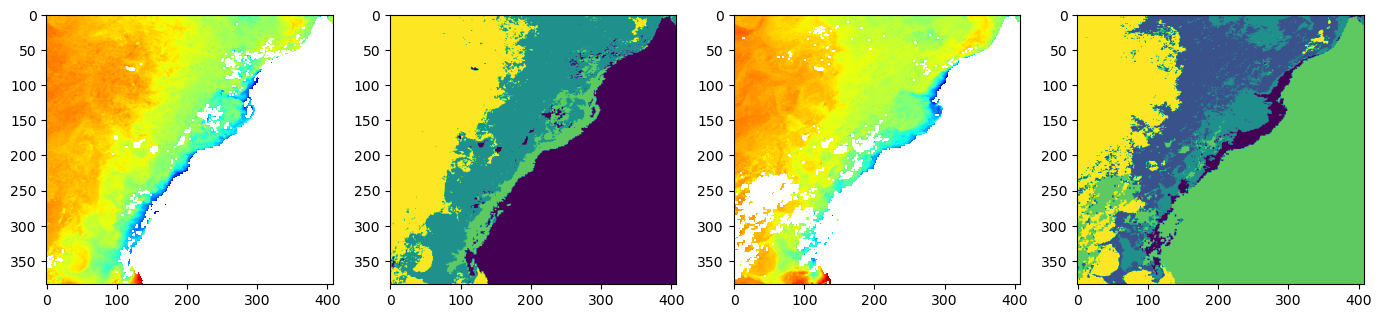

In [112]:
fig , axes = plt.subplots(1, 4 , figsize=(17, 5))
axes = axes.flatten()
for i, file in enumerate(os.listdir("../data/")[6:8]):
    sst4 = nc.Dataset(os.path.join("..","data" ,file))
    sst4 = sst4['sst4'][:]
    sst_norm = read_nc(os.path.join("..","data" ,file))
    axes[0 if i ==0 else 2].imshow(sst4 , cmap= "jet")
    cntr, u, u0, d, jm, p, fpc = fuzzy.cluster.cmeans(sst_norm.T,5 , m=2,error=0.0001,\
                                maxiter=1000,)
    axes[1 if i==0 else 3].imshow(np.argmax(u,axis=0).reshape(shape))
    print(np.unique(np.argmax(u,axis=0)))
    

In [111]:
np.unique(np.argmax(u,axis=0))

array([0, 1, 2, 3], dtype=int64)

Text(0, 0.5, 'silhouette_score')

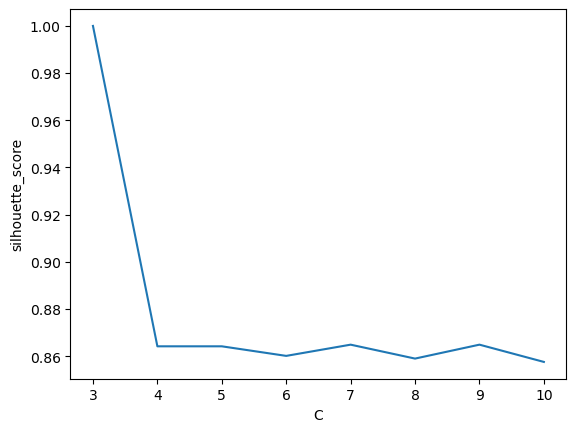

In [70]:
#elbow method
plt.plot([*range(3, c+1)], scores, label="silhouette_score")
plt.xlabel("C")
plt.ylabel("silhouette_score")


In [77]:
cntr, u, u0, d, jm, p, fpc = fuzzy.cluster.cmeans(test_out.T,5 , m=2,error=0.0001,\
                                      maxiter=1000)
labels = np.argmax(u , axis=0)
labels.shape

(156672,)

In [80]:
shape =(384, 408)
labels.reshape(shape)

array([[2, 2, 2, ..., 4, 4, 4],
       [2, 2, 2, ..., 1, 4, 4],
       [2, 2, 2, ..., 4, 4, 4],
       ...,
       [1, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1]], dtype=int64)

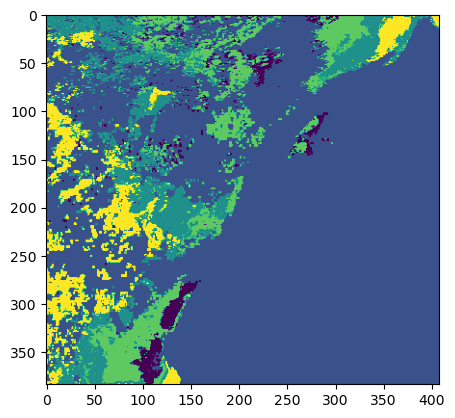

In [87]:
plt.imshow(labels.reshape(shape) )

In [17]:
#save different masks 
from builtins import *
for i in range(1, 6):
    os.mkdir(f"../mask_{i}")
c_means = 5

In [22]:
shape =(384, 408)

In [ ]:
for i , file in enumerate(os.listdir("../data/")[:500]):
    try :
        sst4 = nc.Dataset(os.path.join("..","data" ,file))
        sst4 = sst4['sst4'][:]
        sst_norm = read_nc(os.path.join("..","data" ,file))
    except:
        print(f"this file {file} is not found")
    cntr, u, u0, d, jm, p, fpc = fuzzy.cluster.cmeans(sst_norm.T,5 , m=2,error=0.0001,\
                                maxiter=1000,)
    labels = np.argmax(u , axis=0)
    masks = labels.reshape(shape)
    for label in np.unique(labels):
        mask = np.where(masks == label , 1 , 0).astype(int)
        
        plt.imsave(f"../mask_{int(label)+1}/image_{i+1}.png", mask,cmap="binary")